In [1]:
#Collab bootstrapping for accessing files from google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
#Get test_medium.csv
downloaded = drive.CreateFile({'id':"1nM4xOSa_WPF_9gmFPVMX0LgSXIduTk_X"})
downloaded.GetContentFile('test_medium.csv')

#Get train_medium.csv
downloaded = drive.CreateFile({'id':"1W5RFr2-ZKo-g3nYtPZP2k2-ePHkOKsP2"})
downloaded.GetContentFile('train_medium.csv')

In [3]:
import numpy as np
import collections
import tensorflow as tf
from nltk.tokenize import word_tokenize
from tensorflow.keras import Model, layers
import csv
import re
import pylab
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
MAX_DOCUMENT_LENGTH = 100
HIDDEN_SIZE = 20
EMBEDDING_SIZE = 20
MAX_LABEL = 15

batch_size = 128
no_epochs = 250
lr = 0.01

seed = 10
tf.random.set_seed(seed)

In [5]:
def clean_str(text):
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`\"]", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.strip().lower()

    return text


def build_word_dict(contents):
    words = list()
    for content in contents:
        for word in word_tokenize(clean_str(content)):
            words.append(word)

    word_counter = collections.Counter(words).most_common()
    word_dict = dict()
    word_dict["<pad>"] = 0
    word_dict["<unk>"] = 1
    word_dict["<eos>"] = 2
    for word, _ in word_counter:
        word_dict[word] = len(word_dict)
    return word_dict


def preprocess(contents, word_dict, document_max_len):
    x = list(map(lambda d: word_tokenize(clean_str(d)), contents))
    x = list(map(lambda d: list(map(lambda w: word_dict.get(w, word_dict["<unk>"]), d)), x))
    x = list(map(lambda d: d + [word_dict["<eos>"]], x))
    x = list(map(lambda d: d[:document_max_len], x))
    x = list(map(lambda d: d + (document_max_len - len(d)) * [word_dict["<pad>"]], x))
    return x


def read_data_words():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))

    word_dict = build_word_dict(x_train+x_test)
    x_train = preprocess(x_train, word_dict, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, word_dict, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = [x[:MAX_DOCUMENT_LENGTH] for x in x_train]
    x_test = [x[:MAX_DOCUMENT_LENGTH] for x in x_test]
    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    vocab_size = tf.get_static_value(tf.reduce_max(x_train))
    vocab_size = max(vocab_size, tf.get_static_value(tf.reduce_max(x_test))) + 1
    return x_train, y_train, x_test, y_test, vocab_size

In [6]:
x_train, y_train, x_test, y_test, vocab_size = read_data_words()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [7]:
tf.keras.backend.set_floatx('float32')
class WordRNN(Model):

    def __init__(self, vocab_size, hidden_dim=20):
        super(WordRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.GRUCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation='softmax')

    def call(self, x, drop_rate):
        # forward logic
        embedding = self.embedding(x)
        encoding = self.rnn(embedding)

        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = WordRNN(vocab_size, HIDDEN_SIZE)

In [8]:
# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [9]:
# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

In [10]:
test_acc = []
train_entropy_loss = []
for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for word_id, labels in train_ds:
        train_step(model, word_id, labels, drop_rate=0)

    for word_id, labels in test_ds:
        test_step(model, word_id, labels, drop_rate=0)

    test_acc.append(test_accuracy.result())
    train_entropy_loss.append(train_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))

Epoch 1, Loss: 2.6653261184692383, Accuracy: 0.07035714387893677, Test Loss: 2.645766496658325, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.6467792987823486, Accuracy: 0.07410714030265808, Test Loss: 2.6485254764556885, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.6007845401763916, Accuracy: 0.10035714507102966, Test Loss: 2.363924741744995, Test Accuracy: 0.1428571492433548
Epoch 4, Loss: 1.9089335203170776, Accuracy: 0.2778571546077728, Test Loss: 1.5727052688598633, Test Accuracy: 0.4285714328289032
Epoch 5, Loss: 1.152407169342041, Accuracy: 0.5701785683631897, Test Loss: 1.0156688690185547, Test Accuracy: 0.6557142734527588
Epoch 6, Loss: 0.7139858603477478, Accuracy: 0.7362499833106995, Test Loss: 0.8062688708305359, Test Accuracy: 0.7242857217788696
Epoch 7, Loss: 0.44935938715934753, Accuracy: 0.8500000238418579, Test Loss: 0.701623260974884, Test Accuracy: 0.7971428632736206
Epoch 8, Loss: 0.28197991847991943, Accuracy: 0.9142857193946838, Test Loss: 0.60259050130

No handles with labels found to put in legend.


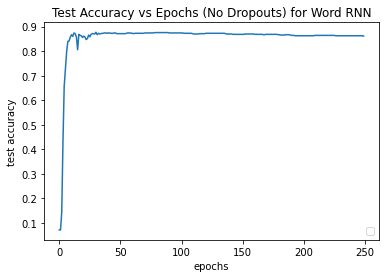

In [11]:
#Plot test accuracy
pylab.figure()
pylab.plot(np.arange(no_epochs), test_acc)
pylab.xlabel('epochs')
pylab.ylabel('test accuracy')
pylab.title('Test Accuracy vs Epochs (No Dropouts) for Word RNN')
pylab.legend(loc='lower right')
pylab.show()

No handles with labels found to put in legend.


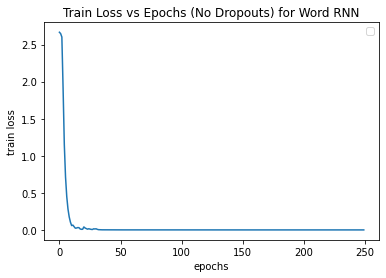

In [12]:
# Plot train loss
pylab.figure()
pylab.plot(np.arange(no_epochs), train_entropy_loss)
pylab.xlabel('epochs')
pylab.ylabel('train loss')
pylab.title('Train Loss vs Epochs (No Dropouts) for Word RNN')
pylab.legend(loc='upper right')
pylab.show()

In [13]:
#Get max test accuracy for comparison
np.max(test_acc)

0.87714285

In [14]:
np.min(train_entropy_loss)

3.4139177e-06